In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
class Tree(object):
    def __init__(self, depth=0, *args, **kwargs):
        self.depth = depth
        self.f_index = 0
        self.w = None
        self.cat_val = None
        self.left = None
        self.right = None

    def set_left(self, l):
        self.left = l

    def set_right(self, r):
        self.right = r

    def set_children(self, l, r):
        self.left = l
        self.right = r

    def set_cat(self, val):
        self.cat_val = val

    def get_cat(self):
        return self.cat_val

    def set_w(self, w, f_index):
        self.w = w
        self.f_index = f_index
    

In [127]:
class DecisionTreeClassification(torch.nn.Module):
    """Normal DecisionTreeClassification"""
    def __init__(self, n_features, cat_indexs=[], max_depth=3,
        ig_func="entropy", *args, **kwargs):
        super(DecisionTreeClassification, self).__init__(*args, **kwargs)
        self.max_depth = max_depth
        self.types = [0]*n_features
        self.tree = None
        for xi in cat_indexs:
            self.types[xi] = 1
        
        if ig_func == 'entropy':
            self.ig_func = DecisionTreeClassification.ig_entropy
        else:
            raise "not an information gain function"

    def train(self, X, Y):
        self.tree = Tree()
        rec_list = [(self.tree, X, Y)]
        while len(rec_list) and rec_list[0][0].depth <= self.max_depth:
            node = rec_list.pop(0)
            f_index, f_val = self.best_split(node[1], node[2])
            node[0].set_w(f_val, f_index)
            node[0].set_cat(self.p_argmax(node[2])[0])
            nl = Tree(node[0].depth + 1)
            nr = Tree(node[0].depth + 1)
            node[0].set_children(nl,nr)
            S = self.split(node[1], node[2], f_index, f_val)
            
            if len(S[2]):
                rec_list.append((nl, S[0], S[2]))

            if len(S[3]):
                rec_list.append((nr, S[1], S[3]))

        return self.tree

    def predict(self, X):
        if self.tree is None:
            return None
        yp = np.empty(len(X))
        for i, xi in enumerate(X):
            yp[i] = self.forward(xi)
        return yp

    def forward(self, x):
        res = None
        node = self.tree
        while res is None:
            ki = x[node.f_index] == node.w if self.types[node.f_index] else x[node.f_index] <= node.w
            if ki:
                if node.left is None or node.left.get_cat() is None:
                    res = node.get_cat()
                else:
                    node = node.left
            else:
                if node.right is None or node.right.get_cat() is None:
                    res = node.get_cat()
                else:
                    node = node.right
        return res

    def split(self, X, Y, f_index, f_val):
        ki = X[:, f_index] == f_val if self.types[f_index] else X[:, f_index] <= f_val
        xl, xr = X[ki], X[~ki]
        yl, yr = Y[ki], Y[~ki]
        return xl, xr, yl, yr        

    def split_feature(self, X, Y, f_index):
        vals = np.unique(X[:, f_index])
        b_ig = 0
        b_val = vals[0]
        for v in vals:
            S = self.split(X, Y, f_index, v)
            if not len(S[2]) or not len(S[3]):
                continue
            ig = self.ig_func(Y, S[2:])
            if ig > b_ig:
                b_ig = ig
                b_val = v
        return b_ig, b_val

    def best_split(self, X, Y):
        b_fi = 0
        b_val = 0
        b_ig = -1
        for i in range(X.shape[1]):
            ig, val = self.split_feature(X, Y, i)
            if ig > b_ig:
                b_ig = ig
                b_val = val
                b_fi = i
        return b_fi, b_val

    @staticmethod
    def propabilities(Y):
        n_classes = {key:0 for key in set(Y)}
        for k in Y:
            n_classes[k] += 1
        for k in n_classes.keys():
            n_classes[k] = n_classes[k]/len(Y)
        return n_classes

    @staticmethod
    def entropy(Y):
        p = DecisionTreeClassification.propabilities(Y)
        return -sum([pi*np.log(pi)/np.log(2) for pi in p.values()])

    @staticmethod
    def ig_entropy(Y_prev, Y_news):
        h = sum([DecisionTreeClassification.entropy(pi)*len(pi)/len(Y_prev) for pi in Y_news])
        return DecisionTreeClassification.entropy(Y_prev) - h

    @staticmethod
    def argmax(Y):
        bi = 0
        bv = Y[0]
        for i, v in enumerate(Y):
            if v > bv:
                bv = v
                bi = i
        return bi

    @staticmethod
    def p_argmax(Y):
        p = DecisionTreeClassification.propabilities(Y)
        bk = list(p.keys())[0]
        bv = p[bk]
        for k in p.keys():
            if p[k] > bv:
                bv = p[k]
                bk = k
        return bk, bv

In [128]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

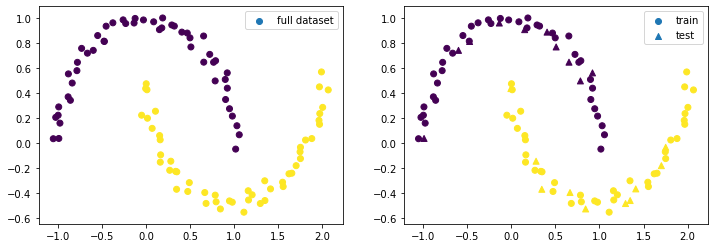

In [129]:
X, Y = make_moons(n_samples=100, noise=0.05, random_state=9)
xtr, xte, ytr, yte = train_test_split(X, Y, test_size=.2, random_state=9)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(X[:,0], X[:,1], c=Y, label='full dataset')
axes[1].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[0].legend()
axes[1].legend()

In [138]:
DTC = DecisionTreeClassification(xtr.shape[1], max_depth=5)
DTC.train(xtr, ytr)

In [139]:
yp1 = DTC.predict(xtr)
yp2 = DTC.predict(xte)
print(yp1)
yp2

[0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 1.]


array([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 1.])

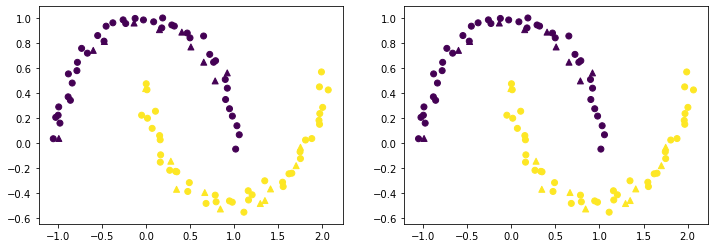

In [140]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

In [159]:
from sklearn.datasets import load_wine

In [164]:
ds = load_wine()
# print(ds.DESCR)
dnp = ds.data
d = pd.DataFrame(ds.data)
d.head()
# ds

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [181]:
xtr, xte, ytr, yte = train_test_split(dnp, ds.target, random_state=9, test_size=.2)
Dwine = DecisionTreeClassification(xtr.shape[1],max_depth=1)
Dwine.train(xtr, ytr)

In [182]:
yptr = Dwine.predict(xtr)
ypte = Dwine.predict(xte)
accure = lambda Yp, Yt: sum(Yp==Yt)/len(Yt) * 100
actr = accure(yptr, ytr)
acte = accure(ypte, yte)
print(f"train acr: {actr}\ntest acr: {acte}")


train acr: 61.97183098591549
test acr: 47.22222222222222
